# 编程练习4：神经网络学习
这次还是解决手写数字识别的问题。ex3中我们使用了已经训练好的神经网络，得到了比逻辑回归更好的效果。ex4我们自己来训练神经网络。
## 1 神经网络
### 1.1 数据可视化
这部分ex3已做过。唯一需要注意的，是将y用one-hot编码时，pandas的get_dummies函数的使用。具体说明见http://blog.csdn.net/mvpboss1004/article/details/79188190

In [34]:
%matplotlib inline
import numpy as np
from scipy.io import loadmat
from random import sample
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import expit
from operator import mul, add
from functools import reduce
from scipy.optimize import fmin_cg

In [19]:
raw_data = loadmat('ex4data1.mat')
X = np.mat(raw_data['X'])
y = np.mat(pd.get_dummies(raw_data['y'].flatten())).astype(np.float)
raw_theta = loadmat('ex4weights.mat')
Theta1 = raw_theta['Theta1']
Theta2 = raw_theta['Theta2']
m = len(y)

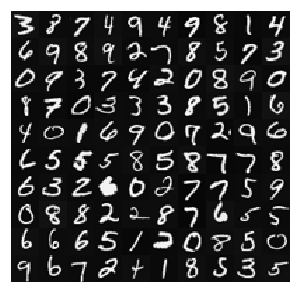

In [20]:
fig = plt.figure(figsize=(5,5))
sample_num = 100
idx = sample(range(0,m), sample_num)
for i in range(0, sample_num):
    plt.subplot(10, 10, i+1)
    plt.imshow(X[idx[i],:].reshape((20,20)).T, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### 1.3 前向传播及代价函数
神经网络代价函数表示为：  
$$J(\theta)=\frac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}[-y_k^{(i)}log((h_\theta(x^{(i)}))_k)-(1-y_k^{(i)})log(1-(h_\theta(x^{(i)}))_k)]$$  
这里y是一个one-hot的矩阵，因此$h_\theta(X)$和y都是m*K的。我们可以用矩阵表示为：  
$$J(\theta)=\frac{1}{m}\sum[-y.*log(h_\Theta(X))-(1-y).*log(1-h_\Theta(X))]$$
注意，这里点乘表示对应元素相乘

In [44]:
def split_line_by_shape(line, shapes):
    start = 0
    mtx = []
    for shape in shapes:
        size = reduce(mul, shape, 1)
        mtx.append(np.mat(line[start:start+size]).reshape(shape))
        start += size
    return mtx
def join_mtx(mtx):
    return np.array(reduce(add, [np.mat(m).flatten().tolist()[0] for m in mtx], []))

def cost(thetas, *args):
    a, y, shapes = args
    start = 0
    for theta in split_line_by_shape(thetas, shapes):
        a = np.column_stack([np.ones((len(a),1)), a])
        z = a * theta.T
        a = expit(z)
    J = np.sum(np.multiply(-y, np.log(a)) - np.multiply(1-y, np.log(1-a))) / len(y)
    return J

shapes = [Theta1.shape, Theta2.shape]
thetas = join_mtx([Theta1,Theta2])
print('Cost: %s\tExpected: 0.287629' % cost(thetas, X, y, shapes))

Cost: 0.287629165161	Expected: 0.287629


### 1.4 正则化代价函数
有了之前的基础，我们可以很快写出矩阵形式表示的正则化代价函数：  
$$J(\theta)=\frac{1}{m}\sum[-y.*log(h_\Theta(X))-(1-y).*log(1-h_\Theta(X))]+\frac{\lambda}{2m}\Theta^{*T}\Theta^{*}$$
注意，这里的$\Theta^*$，是把每一层的theta的偏置项置0。

In [45]:
def costReg(thetas, *args):
    X, y, shapes, lamda = args
    Thetas = np.mat(thetas)
    idx = 0
    for shape in shapes:
        for i in range(0,shape[0]):
            Thetas[0,idx] = 0
            idx += shape[1]
    J = cost(thetas, X, y, shapes) + lamda/(2*len(y))*Thetas*Thetas.T
    return J[0,0]
lamda = 1.0
print('Cost: %s\tExpected: 0.383770' % costReg(thetas, X, y, shapes, lamda))

Cost: 0.420525599823	Expected: 0.383770


## 2 反向传播
这里其实还是用梯度下降法求解。只要能将梯度表示出来，就能求解。这个和之前的思路是一样的。
### 2.2 随机初始化

In [46]:
def randInitializeWeights(L_out, L_in):
    epsilon_init = np.sqrt(6.0 / (L_in+L_out))
    return np.random.rand(L_out, L_in)*2*epsilon_init - epsilon_init
print(randInitializeWeights(2,3))

[[ 0.88629259 -0.27598228 -0.84100909]
 [ 0.53864073 -0.72675402  0.38267812]]


### 2.3 反向传播
反向传播实现起来会比正向麻烦一些。因为正向传播不需要保留上一次迭代的信息，一直原地替换就完了。  
练习中是实现固定层数（3层）的反向传播。为了更好理解，我们实现任意层数的。
推倒的公式看起来很复杂，但最关键的一步是理解：  
$$\Delta^{(l)}:=\Delta^{(l)}+\delta_k^{(l+1)}(a_k^{(l)})^T$$
假如大家熟悉矩阵分块运算，设：
$$\delta^{(l+1)}=\begin{bmatrix}
\delta_1^{(l+1)T}\\
\delta_2^{(l+1)T}\\
...\\
\delta_m^{(l+1)T}
\end{bmatrix}, a^{(l)}=\begin{bmatrix}
a_1^{(l)T}\\
a_2^{(l)T}\\
...\\
a_m^{(l)T}
\end{bmatrix}$$
则  
$$G^{(l)}=\frac{1}{m}[\delta_1^{(l+1)}a_1^{(l)T}+\delta_2^{(l+1)}a_2^{(l)T}+...+\delta_m^{(l+1)}a_m^{(l)T}]=\frac{1}{m}\delta^{(l+1)T}*a^{(l)}$$
而其中
$$\delta^{(l)}=\delta^{(l+1)T}\Theta^{(l)}.*[a^{(l)}.*(1-a^{(l)})]$$
在实现时，非常容易弄乱几者之间的关系。为此我们先手动推算一遍，把所有要用到的变量的维度算出来。  
  
||l=1|l=2|l=3|  
|-:| - | - | - |  
|a|5000x401|5000x26|5000x10|  
|Theata|25x401|10x26||  
|delta||5000x26|5000x10|  

In [47]:
def add_ones(a):
    return np.column_stack([np.ones((len(a),1)), a])
def gza(a, theta):
    return expit(a*theta.T)

def grad(thetas, *args):
    a, y, shapes = args
    m = len(y)
    thetas = split_line_by_shape(thetas, shapes)
    A = []
    for theta in thetas:
        a = add_ones(a)
        A.append(a)
        a = gza(a,theta)
    A.append(a)
    
    D = [0]*len(shapes)
    D[-1] = A[-1] - y
    D[-2] = np.multiply(D[-1]*thetas[-1], np.multiply(A[-2],1-A[-2]))
    for i in range(len(shapes)-3,-1,-1):
        D[i] = np.multiply(D[i+1][:,1:]*thetas[i+1], np.multiply(A[i],1-A[i]))
    #for d in D: print(d.shape)
        
    G = [0]*len(shapes)
    G[-1] = D[-1].T*A[-2] / m
    for i in range(len(shapes)-2,-1,-1):
        G[i] = D[i][:,1:].T * A[i] / m
    #for g in G: print(g.shape)
    return join_mtx(G)

### 2.4 梯度校验
梯度校验可用于检查梯度计算是否正确。我们实现完后，选几行数据来测试一下。  
注，为了兼容后面的正则化梯度，我们将代价函数作为参数传入。

In [49]:
def numGrad(thetas, costFunction, *args):
    epsilon = 1e-4
    numgrad = np.zeros(len(thetas))
    perturb = np.zeros(len(thetas))
    for p in range(0,len(thetas)):
        perturb[p] = epsilon
        loss1 = costFunction(thetas-perturb, *args)
        loss2 = costFunction(thetas+perturb, *args)
        numgrad[p] = (loss2 - loss1) / (2*epsilon)
        perturb[p] = 0
    return numgrad

In [50]:
g1 = np.array(grad(thetas, X[:3], y[:3], shapes))
g2 = np.array(numGrad(thetas, cost, X[:3], y[:3], shapes))
diff = np.linalg.norm(g1-g2) / np.linalg.norm(g1+g2)
print('梯度校验相对误差： %s' % diff)

梯度校验相对误差： 5.95873425905e-10


### 2.5 正则化神经网络
正则化神经网络的梯度，在已算出的梯度基础上加正则化项即可。然后我们将其与梯度校验进行比较。

In [65]:
def gradReg(thetas, *args):
    a, y, shapes, lamda = args
    L = thetas[:]
    idx = 0
    for shape in shapes:
        for i in range(0, shape[0]):
            L[idx] = 0
            idx += shape[1]
    G = grad(thetas, a, y, shapes) + lamda/len(y) * L
    return G
g1 = np.array(gradReg(thetas, X[:3], y[:3], shapes, lamda))
g2 = np.array(numGrad(thetas, costReg, X[:3], y[:3], shapes, lamda))
diff = np.linalg.norm(g1-g2) / np.linalg.norm(g1+g2)
print('梯度校验相对误差： %s' % diff)

梯度校验相对误差： 0.00413109582508


### 2.6 学习参数
与之前一样，我们用fmin_cg函数进行神经网络参数学习。  
如果不限制迭代次数或加入正则项，甚至可以学出100%的准确率，出现过拟合。这里我们两种限制都试一下。

In [61]:
def predict(thetas, X, Y, shapes):
    a = X
    for theta in split_line_by_shape(thetas, shapes):
        a = np.column_stack([np.ones((len(a),1)), a])
        z = a * theta.T
        a = expit(z)
    p = np.argmax(a, axis=1)
    return np.count_nonzero(p == Y-1) / len(Y)

In [66]:
x0 = []
for shape in shapes:
    x0.append(randInitializeWeights(shape[0], shape[1]))
x0 = join_mtx(x0)
Y = raw_data['y']

thetas = fmin_cg(cost, x0, grad, (X,y,shapes), maxiter = 50)
accuracy = predict(thetas, X, Y, shapes)
print('限制迭代次数的准确率： %s' % accuracy)

thetas = fmin_cg(costReg, x0, gradReg, (X,y,shapes,lamda))
accuracy = predict(thetas, X, Y, shapes)
print('加入正则化的准确率： %s' % accuracy)

         Current function value: 0.300569
         Iterations: 50
         Function evaluations: 115
         Gradient evaluations: 115
限制迭代次数的准确率： 0.96
         Current function value: 0.345803
         Iterations: 146
         Function evaluations: 455
         Gradient evaluations: 444
加入正则化的准确率： 0.8912
